# Molecules Calculations Compact

## Old stuff

In [22]:
rmInd = []
boMatrixInAtomic = boToAtomicMatrix.T@createBOMatrix2(C_3_val, rv, *boBasis).astype(float)@boToAtomicMatrix
for i0, _ in enumerate(boMatrixInAtomic):
    isUncoupled=True
    for i1 in range(len(boMatrixInAtomic)):
        if i1 != i0:
            if boMatrixInAtomic[i1,i0] != 0:
                isUncoupled = False
                break
    for i2 in range(len(boMatrixInAtomic[i0])):
        if i2 != i0:
            if boMatrixInAtomic[i0,i2] != 0:
                isUncoupled = False
                break
    if isUncoupled:
        rmInd.append(i0)            
print(rmInd)

NameError: name 'boToAtomicMatrix' is not defined

## 2 Atoms J Basis

Okay so I want to try to start creating some analysis for analyzing 3-body systems. The first thought is to take the fine-structure analysis and instead of calculating things in terms of the BO basis, to calculate it in terms of the atomic basis. I already have some analysis for working in the atomic basis since this is where the fine structure or hyperfine structure is diagonal, so this doesn't sound too hard. If I can express the BO energies in the atomic basis, it seems like it should be not too hard to add a 3rd atom and add all of the individual 2-body interactions to that picture. 

In [38]:
import numpy as np
np.set_printoptions(precision=1,suppress=True,linewidth=100000, edgeitems=10000)
from IPython.display import Latex
import MarksConstants as mc
import Miscellaneous as misc
import matplotlib.pyplot as plt
import sympy as sp
sp.init_printing(use_latex=True)
from sympy.physics.quantum import Bra, Ket, qapply, Dagger as Dag
from sympy.physics.quantum.cg import CG

In [39]:
g = 0
u = 1

In [40]:
class multiplyableDict(dict):
    # This class exists so that I can take a basis ref and use it in np.kron()
    # to programatically get the basis ref for multi-particle systems.
    def __mul__(self, other):
        assert(type(other) == type(self))
        newDict = multiplyableDict()
        for key, value in self.items():
            newDict.update({key+"_1": value})
        for key, value in other.items():
            newDict.update({key+"_2": value})
        return newDict

In [41]:
def createLargerBasisRefs(Lvals, Svals, Ivals, forceExcited=False):
    fBasisRef = []
    for Lv in Lvals:
        for Sv in Svals:
            Jvals = set(np.arange(abs(Sv - Lv), Sv + Lv+1, 1))
            for Jv in Jvals:
                for Iv in Ivals:
                    FVals = set(np.arange(abs(Jv - Iv), Jv + Iv+1, 1))
                    for Fv in FVals:
                        for mf in np.arange(-Fv,Fv+1,1):
                            fBasisRef.append(multiplyableDict({"F":Fv, "mF": mf, "J":Jv, "L":Lv, "S":Sv, "I":Iv}))
    jiBasisRef = []
    for Lv in Lvals:
        for Sv in Svals:
            Jvals = set(np.arange(abs(Sv - Lv), Sv + Lv+1, 1))
            for Jv in Jvals:
                for mJ in np.arange(-Jv,Jv+1,1):
                    for Iv in Ivals:
                        for mi in np.arange(-Iv,Iv+1,1):
                            jiBasisRef.append(multiplyableDict({"J":Jv, "mJ":mJ, "L":Lv, "S":Sv, "I":Iv, "mI":mi}))
    lsiBasisRef = []
    for Lv in Lvals:
        for mL in np.arange(-Lv,Lv+1,1):
            for Sv in Svals:
                for mS in np.arange(-Sv, Sv+1,1):
                    for Iv in Ivals:
                        for mi in np.arange(-Iv,Iv+1,1):
                            lsiBasisRef.append(multiplyableDict({"L":Lv, "mL":mL, "S":Sv, "mS":mS, "I":Iv, "mI":mi}))
    return lsiBasisRef, jiBasisRef, fBasisRef, np.kron(lsiBasisRef,lsiBasisRef), np.kron(jiBasisRef,jiBasisRef), np.kron(fBasisRef,fBasisRef)

In [42]:
def fsOp(basis):
    # expects a two-particle basis, so each element of the basis should 
    # have J_1, mJ_1, L_1, S_1, and J_2, mJ_2, L_2, S_2 values.
    op = np.zeros((len(basis),len(basis)))
    J1,mJ1,L1,S1,J2,mJ2,L2,S2 = [0 for _ in range(8)]
    names = ['J','mJ','L','S']
    for s1num, state1 in enumerate(basis):
        for s2num, state2 in enumerate(basis):
            val = 1
            qNums = [0 for _ in range(8)]
            for num, name in enumerate(names):
                if state2[name+"_1"] != state1[name+"_1"]:
                    # matrix is diagonal.
                    val = 0
                qNums[num] = state1[name+"_1"]
            for num, name in enumerate(names):
                if state2[name+"_2"] != state1[name+"_2"]:
                    # matrix is diagonal.
                    val = 0
                qNums[num+4] = state1[name+"_2"]
            J1,mJ1,L1,S1,J2,mJ2,L2,S2 = qNums
            # the matrix element is A/2 (L1 . S1 + L2 . S2), A=1
            val *= 0.5*(J1*(J1+1)-L1*(L1+1)-S1*(S1+1)+ J2*(J2+1)-L2*(L2+1)-S2*(S2+1) )
            op[s1num,s2num] = val            
    return op

In [43]:
def createBOMatrix2(C3, R, *states):
    # expects states to be a list of lists where the low level list has the values of L, Lambda, S,Sigma, and sigma.
    matrix = np.array([[0.0 for _ in states] for _ in states])
    # the matrix is diagonal.
    for num, state in enumerate(states):
        #L, Lambda, S, Sigma, sigma = state
        sigma = g if state["sigma"]=="g" else u
        p = (-1)**(state["S"]+sigma)
        L = state["L"]
        matrix[num,num] = -p*(3*state["Lambda"]**2-L*(L+1))/R**3 * C3
    return matrix

In [44]:
def createBornOppenheimerBasisHFS(Lvals, Svals, Ivals, sigmavals=["g","u"]):
    # Normal Notaion is |L Lambda sigma S Sigma>, but I need to keep track of more than that for the splittings caused by other interactions.
    # Therefore this creates a very big basis which is probably unnecessary, but the size of the matrices isn't actually prohibitive in these 
    # calculations so it's okay to have degeneracies.
    boBasisRef = []
    for sigma in sigmavals:
        for Lv in Lvals:
            for Lambda in np.arange(-Lv,Lv+1,1):
                for Sv in Svals:
                    for Sigma in np.arange(-Sv, Sv+1,1):
                        for i1 in Ivals:
                            for i2 in Ivals:
                                for I in np.arange(abs(i2-i1), i2+i1+1,1):
                                    for iota in np.arange(-I,I+1,1):
                                        state = multiplyableDict({"L":Lv, "Lambda": Lambda, "sigma": sigma, "S":Sv, "Sigma":Sigma, "i":I, "iota":iota, "i1":i1, "i2":i2,
                                                                  "Omega":Sigma+Lambda, "phi": Sigma+Lambda+iota })
                                        if state not in boBasisRef:
                                            boBasisRef.append(state)
    boBasisRef = list(sorted(boBasisRef, key=lambda state: abs(state["Omega"]) + 100 * ord(state["sigma"])))
    boBasisFancy = []
    for state in boBasisRef:
        spinT = 2*state["S"]+1
        omega = state["Omega"]
        parity = state["sigma"]
        LambdaSymbol = "\Sigma" if state["Lambda"]==0 else "\Pi"
        boBasisFancy.append(Latex(r"$^{"+str(spinT)+ "}" + LambdaSymbol + "_{"+ str(abs(omega)) + "," + parity + "}$"))        
    return boBasisRef, boBasisFancy

In [45]:
def createCouplingMatrix(states, op, offset=-1/2, boBasis=None):
    num = len(states)
    coupleM = np.array([[0.0 for _ in states] for _ in states])
    for num, _ in enumerate(states):
        coupleM[num,num] = offset
    for num1, state1 in enumerate(states):
        misc.reportProgress(num1, len(states))
        for num2, state2 in enumerate(states):
            matElem = state2.T@op@state1
            if boBasis is not None:
                if boBasis[num1]['sigma'] != boBasis[num2]['sigma'] and not math.isclose(matElem, 0, abs_tol=0):
                    continue
                    print(boBasis[num1], '\n', boBasis[num2],'\n', matElem, '\n')
            coupleM[num1,num2] += matElem
    return coupleM    

In [46]:
def BohrOppenheimerToAtomic( oalNums, spinNums, nuclearNums, sigma, 
                             lsBasis, 
                             basisChange=None, naturalKronBasis=None, finalBasis=None ):
    """
    oalNums = (L, Lambda, la, lb)
    L is the total molecular orbital angular momentum \vec{L} = \vec{l1}+\vec{l2}
    Lambda is the projection of L on the internuclear axis.
    l1 is the orbital angular momentum of atom 1.
    l2 is the orbital angular momentum of atom 2.
    
    spinNums = (S, Sigma, sa, sb)
    S is the total molecular spin angular momentum \vec{s} = \vec{s1}+\vec{s2}
    Sigma is the projection of S on the internuclear axis.
    s1 is the spin angular momentum of atom 1.
    s2 is the spin angular momentum of atom 2.
    
    nuclearNums = (I, iota, ia, ib)
    
    sigma is the spatial symmetry of the electronic wavefunctions, 
        either 0 for g ("gerude" or symmetric wavefunctions) 
        or 1 for u ("ungerude" or antisymmetric wavefunctions)
    """
    (L, Lambda, la, lb) = oalNums
    (S, Sigma, sa, sb) = spinNums
    (I, iota, ia, ib) = nuclearNums
    state = 0
    p = (-1)**(S+sigma)
    indvCont = []
    lsiBasisStates = []
    otherBasisStates = []
    for mla in np.arange(-la,la+1,1):
        mlb = Lambda-mla
        if abs(mlb) > lb:
            continue
        for msa in np.arange(-sa,sa+1,1):
            msb = Sigma-msa
            if abs(msb) > sb:
                continue
            for mia in np.arange(-ia, ia+1, 1):
                mib = iota-mia
                if abs(mib) > ib:
                    continue
                # CG notation is <j1,mj1,j2,mj2|j3,mj3>
                oalCoef = float(CG(la,mla,lb,mlb,L,Lambda).doit())
                spinCoef = float(CG(sa,msa,sb,msb,S,Sigma).doit())
                nuclearCoef = float(CG(ia,mia,ib,mib,I,iota).doit())
                aState1 = getColumnState(lsiBasis, {'L':la,'mL':mla,'S':sa,'mS':msa, 'I':ia,'mI':mia})
                bState1 = getColumnState(lsiBasis, {'L':lb,'mL':mlb,'S':sb,'mS':msb, 'I':ib,'mI':mib})
                aState2 = getColumnState(lsiBasis, {'L':lb,'mL':mlb,'S':sa,'mS':msa, 'I':ia,'mI':mia})
                bState2 = getColumnState(lsiBasis, {'L':la,'mL':mla,'S':sb,'mS':msb, 'I':ib,'mI':mib})
                if oalCoef != 0 and nuclearCoef != 0 and spinCoef != 0:
                    lsiBasisStates.append([aState1, bState1, aState2, bState2])
                if basisChange is not None:
                    aState1 = basisChange@aState1
                    bState1 = basisChange@bState1
                    aState2 = basisChange@aState2
                    bState2 = basisChange@bState2
                newpart = nuclearCoef*oalCoef*spinCoef * (np.kron(aState1,bState1) + p * np.kron(aState2,bState2))
                
                state += newpart
                if oalCoef != 0 and nuclearCoef != 0 and spinCoef != 0:
                    indvCont.append(newpart)
                    otherBasisStates.append([aState1, bState1, aState2, bState2])
    if np.linalg.norm(state) == 0:
        raise ValueError("State has zero norm!")
    state /= np.linalg.norm(state)
    if finalBasis is not None:
        state = convertToReducedBasis(state, finalBasis, naturalKronBasis)
    return state, np.array(indvCont), np.array(lsiBasisStates), np.array(otherBasisStates)

In [47]:
def convertToReducedBasis(state, finBasis, origBasis):
    assert(len(state) == len(origBasis))
    newState = np.zeros((len(finBasis),1))
    for num, origState in enumerate(origBasis):
        if state[num] != 0:
            comp = state[num]*getColumnState(finBasis, origState)
            newState += comp
    return newState

In [48]:
def getColumnState(basis, quantumNums):
    assert(len(basis[0])==len(quantumNums))
    colState = [[0] for _ in range(len(basis))]
    for num, state in enumerate(basis):
        match = True
        for qnum, val in quantumNums.items():
            if val != state[qnum]:
                match = False
        if match:
            colState[num][0] = 1
            return colState
    raise ValueError("No Match! nums were" + str(quantumNums))

In [49]:
def lsiToJi(lsiBasis, jiBasis):
    # expects single atom bases
    assert(len(lsiBasis)==len(jiBasis))
    op = np.zeros((len(lsiBasis),len(jiBasis)))
    for lsnum, lsiState in enumerate(lsiBasis):
        for jnum, jiState in enumerate(jiBasis):
            # there should be some repeats because of the i values in each basis
            L, mL, S, mS, I_lsi, mI_lsi = [lsiState[key] for key in ['L','mL','S','mS', 'I', 'mI']]
            J, mJ, JL, JS, I_ji, mI_ji = [jiState[key] for key in ['J','mJ', 'L', 'S', 'I', 'mI']]
            # needing to handle this case makes me feel like the actual clebsh gordon coef should be written as
            # <L,mL,S,mS|J,mJ,L2,S2> or so instead of <L,mL,S,mS|J,mJ> as it usually is written. 
            if JL != L or JS != S or I_lsi != I_ji or mI_lsi != mI_ji:
                op[jnum,lsnum] = 0
            else:
                op[jnum,lsnum] += float(CG(L, mL, S, mS, J, mJ).doit())
    return op

In [50]:
# plugging in zero nuclear spin effectively avoids i in all of these bases. 
lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = createLargerBasisRefs([0,1], [1/2], [0])
JbasisR = []
for state in jiBasis2Atom:
    if (state['L_1'] == 0 and state['L_2'] == 0) or (state['L_1'] == 1 and state['L_2'] == 1):
        continue
    JbasisR.append(state)
#fsOperator = fsOp(jiBasis2Atom)
fsRed = fsOp(JbasisR)
lsiToJiop = lsiToJi(lsiBasis,jiBasis)
boBasisDict_g, boBasisLatex_g = createBornOppenheimerBasisHFS([1],[0,1], [0], sigmavals=['g'])
boBasisDict_u, boBasisLatex_u = createBornOppenheimerBasisHFS([1],[0,1], [0], sigmavals=['u'])
boBasisDict_full, boBasisLatex_full = createBornOppenheimerBasisHFS([1],[0,1], [0], sigmavals=['g', 'u'])

In [51]:
boBasis0mg = []
boBasisDict_full;
boQns = ['L','Lambda', 'S', 'Sigma','sigma']
stateList = [[1, 0, 1, 0, 'g'], [1, -1, 1, 1, 'g'], [1, 1, 1, -1, 'g'], [1,0,0,0,'g']]
for boVals in stateList:
    for bostate in boBasisDict_full:
        match=True
        for qn, val in zip(boQns, boVals):
            if bostate[qn] != val:
                match=False
                break
        if match:
            boBasis0mg.append(bostate)

In [15]:
boBasis = boBasisDict_full

In [16]:
boToAtomicMatrix = []
for st in boBasis: 
    sigmaV = g if st['sigma']=='g' else u
    phase = (-1)**(sigmaV+st['S'])
    state1, _,_,_ = BohrOppenheimerToAtomic( [st['L'],st['Lambda'],st['L'],0],
                                                [st['S'],st['Sigma'],1/2,1/2],
                                                [st['i'],st['iota'],0,0],
                                                sigmaV, lsiBasis, basisChange=lsiToJiop, naturalKronBasis=jiBasis2Atom, finalBasis=JbasisR)
    boToAtomicMatrix.append(state1.T[0])
boToAtomicMatrix = np.array(boToAtomicMatrix)

In [17]:
A_gs = (mc.Rb87_Ground_ToF2-mc.Rb87_Ground_ToF1)/2
A_12 = (mc.Rb87_5P12_ToF2-mc.Rb87_5P12_ToF1)/2
A_32 = (mc.Rb87_5P32_ToF3-mc.Rb87_5P32_ToF0)/6

In [18]:
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h
C_3_val = mc.Rb87_C3
print(DeltaVal, C_3_val)

4.7197635548748796e-21 5.94492796981645e-48


In [19]:
Rvals = np.linspace( 0.5*20*mc.a0, 10*20*mc.a0, 20000 )
data = []
#eEnergy = electronicEnergy(jiBasis2Atom)
for rnum, rv in enumerate(Rvals):
    misc.reportProgress(rnum, len(Rvals))
    t1 = boToAtomicMatrix.T@createBOMatrix2(C_3_val, rv, *boBasis).astype(float)@boToAtomicMatrix
    t2 = fsRed * 2 * DeltaVal / 3
    rmatrix = t1 + t2
    eigVals = np.linalg.eigvalsh(rmatrix)
    data.append(eigVals)

C:\ProgramData\Miniconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


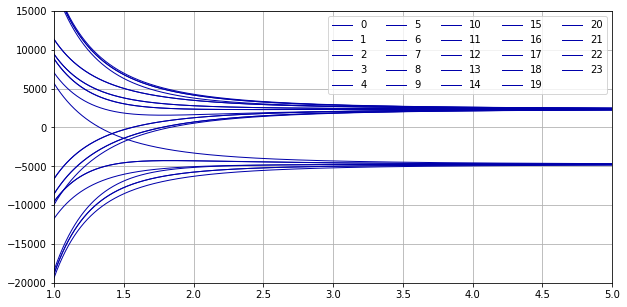

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
colors, _ = misc.getColors(len(misc.transpose(data))+1)
linestyles = ['-',':','--']
yoff = 0
for datanum, (mdata, color) in enumerate(zip(misc.transpose(data), colors)):
    ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoff, linewidth=1, label=datanum, color='#0000AA', linestyle='-')
ax.legend(ncol=5)
ax.set_xlim(1,5)
ax.set_ylim(-20000,15000)
ax.grid()

## 2 Atoms LS Basis

In [184]:
def lsiToJi(lsiBasis, jiBasis):
    # expects single atom bases
    assert(len(lsiBasis)==len(jiBasis))
    op = np.zeros((len(lsiBasis),len(jiBasis)))
    for lsnum, lsiState in enumerate(lsiBasis):
        for jnum, jiState in enumerate(jiBasis):
            # there should be some repeats because of the i values in each basis
            L, mL, S, mS, I_lsi, mI_lsi = [lsiState[key] for key in ['L','mL','S','mS', 'I', 'mI']]
            J, mJ, JL, JS, I_ji, mI_ji = [jiState[key] for key in ['J','mJ', 'L', 'S', 'I', 'mI']]
            # needing to handle this case makes me feel like the actual clebsh gordon coef should be written as
            # <L,mL,S,mS|J,mJ,L2,S2> or so instead of <L,mL,S,mS|J,mJ> as it usually is written. 
            if JL != L or JS != S or I_lsi != I_ji or mI_lsi != mI_ji:
                op[jnum,lsnum] = 0
            else:
                op[jnum,lsnum] += float(CG(L, mL, S, mS, J, mJ).doit())
    return op

In [186]:
def J_to_LS(lsiBasis, jiBasis):
    assert(len(lsiBasis)==len(jiBasis))
    op = np.zeros((len(lsiBasis),len(jiBasis)))
    for lsnum, lsiState in enumerate(lsiBasis):
        for jnum, jiState in enumerate(jiBasis):
            # there should be some repeats because of the i values in each basis unless I=0
            L1, mL1, S1, mS1, I_lsi1, mI_lsi1 = [lsiState[key] for key in ['L_1','mL_1','S_1','mS_1', 'I_1', 'mI_1']]
            J1, mJ1, JL1, JS1, I_ji1, mI_ji1 = [jiState[key] for key in ['J_1','mJ_1', 'L_1', 'S_1', 'I_1', 'mI_1']]
            L2, mL2, S2, mS2, I_lsi2, mI_lsi2 = [lsiState[key] for key in ['L_2','mL_2','S_2','mS_2', 'I_2', 'mI_2']]
            J2, mJ2, JL2, JS2, I_ji2, mI_ji2 = [jiState[key] for key in ['J_2','mJ_2', 'L_2', 'S_2', 'I_2', 'mI_2']]
            # needing to handle this case makes me feel like the actual clebsh gordon coef should be written as
            # <L,mL,S,mS|J,mJ,L2,S2> or so instead of <L,mL,S,mS|J,mJ> as it usually is written. 
            if JL1 != L1 or JS1 != S1 or I_lsi1 != I_ji1 or mI_lsi1 != mI_ji1:
                op[jnum,lsnum] = 0
            elif JL2 != L2 or JS2 != S2 or I_lsi2 != I_ji2 or mI_lsi2 != mI_ji2:
                op[jnum,lsnum] = 0
            else:
                op[jnum,lsnum] += float(CG(L1, mL1, S1, mS1, J1, mJ1).doit())*float(CG(L2, mL2, S2, mS2, J2, mJ2).doit())
    return op

In [187]:
# plugging in zero nuclear spin effectively avoids i in all of these bases. 
lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = createLargerBasisRefs([0,1], [1/2], [0])
lsBasisR, jBasisR = [], []
for state in lsiBasis2Atom:
    if (state['L_1'] == 0 and state['L_2'] == 0) or (state['L_1'] == 1 and state['L_2'] == 1):
        continue
    lsBasisR.append(state)
for state in jiBasis2Atom:
    if (state['L_1'] == 0 and state['L_2'] == 0) or (state['L_1'] == 1 and state['L_2'] == 1):
        continue
    jBasisR.append(state)
fsOperator = fsOp(jBasisR)
J_to_LS_op = J_to_LS(lsBasisR,jBasisR)
fsOp_LS = J_to_LS_op@fsOperator@J_to_LS_op.T
print(len(lsBasisR))
lsiToJiop = lsiToJi(lsiBasis,jiBasis)
print(lsiToJiop.shape)
#fsLsi = lsiToJiop.T@fsOperator@lsiToJiop
#boBasisDict_g, boBasisLatex_g = createBornOppenheimerBasisHFS([1],[0,1], [0], sigmavals=['g'])
#boBasisDict_u, boBasisLatex_u = createBornOppenheimerBasisHFS([1],[0,1], [0], sigmavals=['u'])
#boBasisDict_full, boBasisLatex_full = createBornOppenheimerBasisHFS([1],[0,1], [0], sigmavals=['g', 'u'])

24
(8, 8)


In [189]:
boBasis = boBasisDict_full

In [190]:
boToAtomicMatrix = []
for st in boBasis: 
    sigmaV = g if st['sigma']=='g' else u
    phase = (-1)**(sigmaV+st['S'])
    state1, _,_,_ = BohrOppenheimerToAtomic( [st['L'],st['Lambda'],st['L'],0],
                                                [st['S'],st['Sigma'],1/2,1/2],
                                                [st['i'],st['iota'],0,0],
                                                sigmaV, lsiBasis, basisChange=lsiToJiop, naturalKronBasis=jiBasis2Atom, finalBasis=jBasisR)
    boToAtomicMatrix.append(state1.T[0])
boToAtomicMatrix = np.array(boToAtomicMatrix)
#boToAtomicMatrix = J_to_LS_op @ np.array(boToAtomicMatrix)

In [191]:
A_gs = (mc.Rb87_Ground_ToF2-mc.Rb87_Ground_ToF1)/2
A_12 = (mc.Rb87_5P12_ToF2-mc.Rb87_5P12_ToF1)/2
A_32 = (mc.Rb87_5P32_ToF3-mc.Rb87_5P32_ToF0)/6

In [192]:
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h
C_3_val = mc.Rb87_C3
print(DeltaVal, C_3_val)

4.7197635548748796e-21 5.94492796981645e-48


In [195]:
print(getColumnState(jBasisR, jBasisR[2]))
print(jBasisR[-2])
print(lsBasisR[-2])

[[0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
{'J_1': 1.5, 'mJ_1': 1.5, 'L_1': 1, 'S_1': 0.5, 'I_1': 0, 'mI_1': 0, 'J_2': 0.5, 'mJ_2': -0.5, 'L_2': 0, 'S_2': 0.5, 'I_2': 0, 'mI_2': 0}
{'L_1': 1, 'mL_1': 1, 'S_1': 0.5, 'mS_1': 0.5, 'I_1': 0, 'mI_1': 0, 'L_2': 0, 'mL_2': 0, 'S_2': 0.5, 'mS_2': -0.5, 'I_2': 0, 'mI_2': 0}


In [203]:
def HC(matrix):
    return matrix.conj().T

In [206]:
toAtomic = boToAtomicMatrix@HC(J_to_LS_op)

In [207]:
Rvals = np.linspace( 0.5*20*mc.a0, 5*20*mc.a0, 5000 )
data = []
for rnum, rv in enumerate(Rvals):
    misc.reportProgress(rnum, len(Rvals))
    #t1 = J_to_LS_op@boToAtomicMatrix.T@createBOMatrix2(C_3_val, rv, *boBasis).astype(float)@boToAtomicMatrix@J_to_LS_op.T
    t1 = HC(toAtomic)@createBOMatrix2(C_3_val, rv, *boBasis).astype(float)@toAtomic
    t2 = fsOp_LS * 2 * DeltaVal / 3
    rmatrix = t1 + t2
    eigVals = np.linalg.eigvalsh(rmatrix)
    data.append(eigVals)

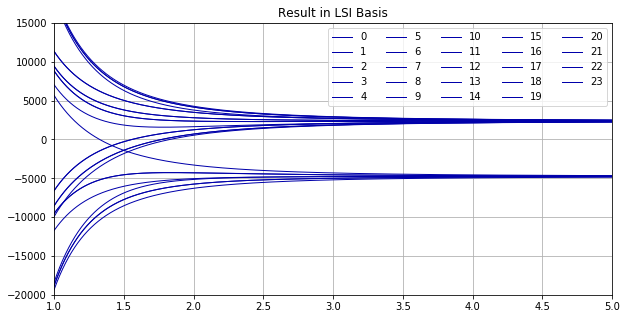

In [208]:
fig, ax = plt.subplots(figsize=(10, 5))
colors, _ = misc.getColors(len(misc.transpose(data))+1)
linestyles = ['-',':','--']
for datanum, (mdata, color) in enumerate(zip(misc.transpose(data), colors)):
    ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, linewidth=1, label=datanum, color='#0000AA', linestyle='-')
ax.legend(ncol=5)
ax.set_xlim(1,5)
ax.set_ylim(-20000,15000)
ax.grid()
ax.set_title('Result in LSI Basis');

so close...

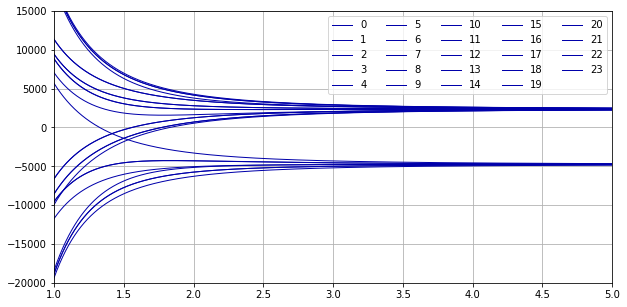

## 2-Atoms Rotated

this should give the same result as above since I'm rotating the whole basis

### constructing the rotation operator

$$
R(\theta) = \exp\{-\frac{i\theta}{\hbar}\hat{n}\bullet\vec{J}\}
$$

In [63]:
from scipy.linalg import expm, sinm, cosm
expm([[1,0],[0,-1]])

array([[2.7, 0. ],
       [0. , 0.4]])

In [116]:
def rotateM(theta, Sz):
    #sigmax = np.array([[0,1],[1,0]])
    #sigmay = np.array([[0,1j],[-1j,0]])
    #sigmaz = np.array([[1,0],[0,-1]])
    return expm(-1j*theta/2*Sz)

In [126]:
rotateM(4*np.pi, createSpinMatrix(1,"Sz"))

array([[ 1.-0.j, -0.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  1.+0.j]])

In [105]:
def delta(ms1,ms2):
    if ms1==ms2:
        return 1
    return 0
def createSpinMatrix(spin, which):
    assert(which == "Sx" or which == "Sy" or which == "Sz")
    assert(int(2*spin) == float(2*spin))
    mS_vals = np.arange(-spin,spin+1,1)
    Sm = np.zeros((len(mS_vals),len(mS_vals)), dtype=complex)
    for i1, ms1 in enumerate(mS_vals):
        for i2, ms2 in enumerate(mS_vals):
            if which == "Sx":
                Sm[i1,i2] = (delta(ms2,ms1+1) + delta(ms2+1,ms1)) * 0.5 * np.sqrt(spin*(spin+1)-ms1*ms2)
            elif which == "Sy":
                Sm[i1,i2] = (delta(ms2,ms1+1) - delta(ms2+1,ms1)) * 0.5j * np.sqrt(spin*(spin+1)-ms1*ms2)
            elif which == "Sz":
                Sm[i1,i2] = delta(ms2,ms1)*ms1
    return Sm

In [114]:
createSpinMatrix(1,'Sy')

array([[0.+0.j , 0.+0.7j, 0.+0.j ],
       [0.-0.7j, 0.+0.j , 0.+0.7j],
       [0.+0.j , 0.-0.7j, 0.+0.j ]])

In [149]:
def createRotationMatrix(basis, theta, spinToRotate):
    Rm = np.zeros((len(basis), len(basis)), dtype=complex)
    for i1, state1 in enumerate(basis):
        for i2, state2 in enumerate(basis):
            coupled=True
            for k1,k2 in zip(state1.keys(), state2.keys()):
                assert(k1==k2)
                if (k1 != "m" + spinToRotate) and state1[k1] != state2[k2]:
                    coupled=False
            if not coupled:
                Rm[i1, i2] = 0
            else:
                assert(state1[spinToRotate] == state2[spinToRotate])
                spv = state1[spinToRotate]
                rm_small = rotateM(theta, createSpinMatrix(spv,"Sx"))
                rm_i1 = list(np.arange(-spv, spv+1)).index(state1["m"+spinToRotate])
                rm_i2 = list(np.arange(-spv, spv+1)).index(state2["m"+spinToRotate])
                Rm[i1,i2] = rm_small[rm_i1,rm_i2]
    return Rm

In [170]:
def fullRotation(theta):
    RmL1 = createRotationMatrix(lsBasisR, theta, 'L_1')
    RmL2 = createRotationMatrix(lsBasisR, theta, 'L_2')
    RmS1 = createRotationMatrix(lsBasisR, theta, 'S_1')
    RmS2 = createRotationMatrix(lsBasisR, theta, 'S_2')
    return RmL1@RmL2@RmS1@RmS2

## analysis...

In [209]:
# plugging in zero nuclear spin effectively avoids i in all of these bases. 
lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = createLargerBasisRefs([0,1], [1/2], [0])
lsBasisR, jBasisR = [], []
for state in lsiBasis2Atom:
    if (state['L_1'] == 0 and state['L_2'] == 0) or (state['L_1'] == 1 and state['L_2'] == 1):
        continue
    lsBasisR.append(state)
for state in jiBasis2Atom:
    if (state['L_1'] == 0 and state['L_2'] == 0) or (state['L_1'] == 1 and state['L_2'] == 1):
        continue
    jBasisR.append(state)
fsOperator = fsOp(jBasisR)
J_to_LS_op = J_to_LS(lsBasisR,jBasisR)
fsOp_LS = J_to_LS_op@fsOperator@J_to_LS_op.T
print(len(lsBasisR))
lsiToJiop = lsiToJi(lsiBasis,jiBasis)
print(lsiToJiop.shape)
#fsLsi = lsiToJiop.T@fsOperator@lsiToJiop
#boBasisDict_g, boBasisLatex_g = createBornOppenheimerBasisHFS([1],[0,1], [0], sigmavals=['g'])
#boBasisDict_u, boBasisLatex_u = createBornOppenheimerBasisHFS([1],[0,1], [0], sigmavals=['u'])
boBasisDict_full, boBasisLatex_full = createBornOppenheimerBasisHFS([1],[0,1], [0], sigmavals=['g', 'u'])

24
(8, 8)


In [210]:
boBasis = boBasisDict_full

In [211]:
boToAtomicMatrix = []
for st in boBasis: 
    sigmaV = g if st['sigma']=='g' else u
    phase = (-1)**(sigmaV+st['S'])
    state1, _,_,_ = BohrOppenheimerToAtomic( [st['L'],st['Lambda'],st['L'],0],
                                                [st['S'],st['Sigma'],1/2,1/2],
                                                [st['i'],st['iota'],0,0],
                                                sigmaV, lsiBasis, basisChange=lsiToJiop, naturalKronBasis=jiBasis2Atom, finalBasis=jBasisR)
    boToAtomicMatrix.append(state1.T[0])
boToAtomicMatrix = np.array(boToAtomicMatrix)
#boToAtomicMatrix = J_to_LS_op @ np.array(boToAtomicMatrix)

In [212]:
A_gs = (mc.Rb87_Ground_ToF2-mc.Rb87_Ground_ToF1)/2
A_12 = (mc.Rb87_5P12_ToF2-mc.Rb87_5P12_ToF1)/2
A_32 = (mc.Rb87_5P32_ToF3-mc.Rb87_5P32_ToF0)/6

In [213]:
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h
C_3_val = mc.Rb87_C3
print(DeltaVal, C_3_val)

4.7197635548748796e-21 5.94492796981645e-48


In [214]:
print(getColumnState(jBasisR, jBasisR[2]))
print(jBasisR[-2])
print(lsBasisR[-2])

[[0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
{'J_1': 1.5, 'mJ_1': 1.5, 'L_1': 1, 'S_1': 0.5, 'I_1': 0, 'mI_1': 0, 'J_2': 0.5, 'mJ_2': -0.5, 'L_2': 0, 'S_2': 0.5, 'I_2': 0, 'mI_2': 0}
{'L_1': 1, 'mL_1': 1, 'S_1': 0.5, 'mS_1': 0.5, 'I_1': 0, 'mI_1': 0, 'L_2': 0, 'mL_2': 0, 'S_2': 0.5, 'mS_2': -0.5, 'I_2': 0, 'mI_2': 0}


In [215]:
def HC(matrix):
    return matrix.conj().T

In [216]:
toAtomic = boToAtomicMatrix@HC(J_to_LS_op)

In [222]:
Rvals = np.linspace( 0.5*20*mc.a0, 5*20*mc.a0, 5000 )
data = []
rotMatrix = fullRotation(1)
for rnum, rv in enumerate(Rvals):
    misc.reportProgress(rnum, len(Rvals))
    #t1 = J_to_LS_op@boToAtomicMatrix.T@createBOMatrix2(C_3_val, rv, *boBasis).astype(float)@boToAtomicMatrix@J_to_LS_op.T
    t1 = HC(toAtomic)@createBOMatrix2(C_3_val, rv, *boBasis).astype(float)@toAtomic
    t2 = fsOp_LS * 2 * DeltaVal / 3
    rmatrix = t1 + t2
    rotatedH = HC(rotMatrix)@rmatrix@rotMatrix
    eigVals = np.linalg.eigvalsh(rotatedH)
    data.append(eigVals)

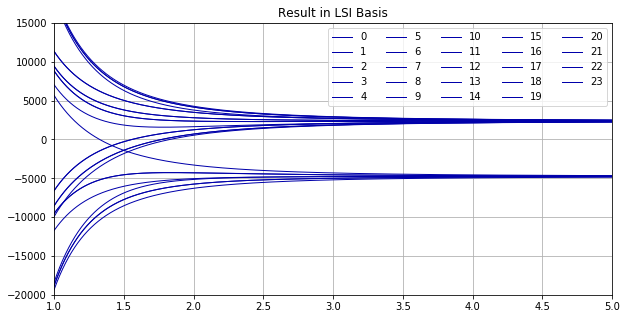

In [223]:
fig, ax = plt.subplots(figsize=(10, 5))
colors, _ = misc.getColors(len(misc.transpose(data))+1)
linestyles = ['-',':','--']
for datanum, (mdata, color) in enumerate(zip(misc.transpose(data), colors)):
    ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, linewidth=1, label=datanum, color='#0000AA', linestyle='-')
ax.legend(ncol=5)
ax.set_xlim(1,5)
ax.set_ylim(-20000,15000)
ax.grid()
ax.set_title('Result in LSI Basis');

for ref:

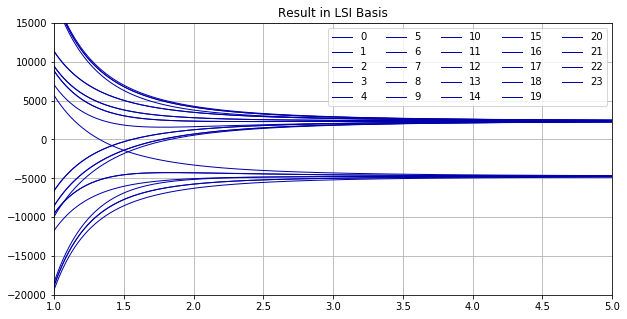

# 3-Atoms attempt 2

Okay so the basic idea is going to be to calculate the energy of a pair *once* at all the distances using the normal method above, and then rotate the states if needed and then convert them to 3-Atom basis. the last part might be a bit slow, but should work out fine I think.

In [76]:
from scipy.linalg import expm, sinm, cosm
expm([[1,0],[0,-1]])

array([[2.7, 0. ],
       [0. , 0.4]])

In [78]:
def rotateM(theta, Sz):
    #sigmax = np.array([[0,1],[1,0]])
    #sigmay = np.array([[0,1j],[-1j,0]])
    #sigmaz = np.array([[1,0],[0,-1]])
    return expm(-1j*theta/2*Sz)

In [383]:
def fsOp3(basis):
    # expects a two-particle basis, so each element of the basis should 
    # have J_1, mJ_1, L_1, S_1, and J_2, mJ_2, L_2, S_2 values.
    op = np.zeros((len(basis),len(basis)))
    J1,mJ1,L1,S1,J2,mJ2,L2,S2 = [0 for _ in range(8)]
    names = ['J','mJ','L','S']
    for s1num, state1 in enumerate(basis):
        for s2num, state2 in enumerate(basis):
            val = 1
            qNums = [0 for _ in range(12)]
            for num, name in enumerate(names):
                if state2[name+"_1"] != state1[name+"_1"]:
                    # matrix is diagonal.
                    val = 0
                qNums[num] = state1[name+"_1"]
            for num, name in enumerate(names):
                if state2[name+"_2"] != state1[name+"_2"]:
                    # matrix is diagonal.
                    val = 0
                qNums[num+4] = state1[name+"_2"]
            for num, name in enumerate(names):
                if state2[name+"_3"] != state1[name+"_3"]:
                    # matrix is diagonal.
                    val = 0
                qNums[num+8] = state1[name+"_3"]
            J1,mJ1,L1,S1,J2,mJ2,L2,S2,J3,mJ3,L3,S3, = qNums
            # the matrix element is A/2 (L1 . S1 + L2 . S2), A=1
            val *= 0.5*(J1*(J1+1)-L1*(L1+1)-S1*(S1+1)+ J2*(J2+1)-L2*(L2+1)-S2*(S2+1) + J3*(J3+1)-L3*(L3+1)-S3*(S3+1))
            #val *= 0.5*(J1*(J1+1)-L1*(L1+1)-S1*(S1+1)+ J2*(J2+1)-L2*(L2+1)-S2*(S2+1))
            op[s1num,s2num] = val
    return op

In [276]:
def J_to_LS3(lsiBasis, jiBasis):
    assert(len(lsiBasis)==len(jiBasis))
    op = np.zeros((len(lsiBasis),len(jiBasis)))
    for lsnum, lsiState in enumerate(lsiBasis):
        for jnum, jiState in enumerate(jiBasis):
            # there should be some repeats because of the i values in each basis unless I=0
            L1, mL1, S1, mS1, I_lsi1, mI_lsi1 = [lsiState[key] for key in ['L_1','mL_1','S_1','mS_1', 'I_1', 'mI_1']]
            J1, mJ1, JL1, JS1, I_ji1, mI_ji1 = [jiState[key] for key in ['J_1','mJ_1', 'L_1', 'S_1', 'I_1', 'mI_1']]
            L2, mL2, S2, mS2, I_lsi2, mI_lsi2 = [lsiState[key] for key in ['L_2','mL_2','S_2','mS_2', 'I_2', 'mI_2']]
            J2, mJ2, JL2, JS2, I_ji2, mI_ji2 = [jiState[key] for key in ['J_2','mJ_2', 'L_2', 'S_2', 'I_2', 'mI_2']]
            L3, mL3, S3, mS3, I_lsi3, mI_lsi3 = [lsiState[key] for key in ['L_3','mL_3','S_3','mS_3', 'I_3', 'mI_3']]
            J3, mJ3, JL3, JS3, I_ji3, mI_ji3 = [jiState[key] for key in ['J_3','mJ_3', 'L_3', 'S_3', 'I_3', 'mI_3']]
            # needing to handle this case makes me feel like the actual clebsh gordon coef should be written as
            # <L,mL,S,mS|J,mJ,L2,S2> or so instead of <L,mL,S,mS|J,mJ> as it usually is written. 
            if JL1 != L1 or JS1 != S1 or I_lsi1 != I_ji1 or mI_lsi1 != mI_ji1:
                op[jnum,lsnum] = 0
            elif JL2 != L2 or JS2 != S2 or I_lsi2 != I_ji2 or mI_lsi2 != mI_ji2:
                op[jnum,lsnum] = 0
            elif JL3 != L3 or JS3 != S3 or I_lsi3 != I_ji3 or mI_lsi3 != mI_ji3:
                op[jnum,lsnum] = 0
            else:
                op[jnum,lsnum] += float(CG(L1, mL1, S1, mS1, J1, mJ1).doit())*float(CG(L2, mL2, S2, mS2, J2, mJ2).doit())*float(CG(L3, mL3, S3, mS3, J3, mJ3).doit())
    return op

In [256]:
def delta(ms1,ms2):
    if ms1==ms2:
        return 1
    return 0
def createSpinMatrix(spin, which):
    assert(which == "Sx" or which == "Sy" or which == "Sz")
    assert(int(2*spin) == float(2*spin))
    mS_vals = np.arange(-spin,spin+1,1)
    Sm = np.zeros((len(mS_vals),len(mS_vals)), dtype=complex)
    for i1, ms1 in enumerate(mS_vals):
        for i2, ms2 in enumerate(mS_vals):
            if which == "Sx":
                Sm[i1,i2] = (delta(ms2,ms1+1) + delta(ms2+1,ms1)) * 0.5 * np.sqrt(spin*(spin+1)-ms1*ms2)
            elif which == "Sy":
                Sm[i1,i2] = (delta(ms2,ms1+1) - delta(ms2+1,ms1)) * 0.5j * np.sqrt(spin*(spin+1)-ms1*ms2)
            elif which == "Sz":
                Sm[i1,i2] = delta(ms2,ms1)*ms1
    return Sm

In [258]:
def fullRotation(theta):
    RmL1 = createRotationMatrix(lsBasisR, theta, 'L_1')
    RmL2 = createRotationMatrix(lsBasisR, theta, 'L_2')
    RmS1 = createRotationMatrix(lsBasisR, theta, 'S_1')
    RmS2 = createRotationMatrix(lsBasisR, theta, 'S_2')
    return RmL1@RmL2@RmS1@RmS2

In [302]:
def HC(matrix):
    return matrix.conj().T

In [404]:
from scipy.linalg import expm, sinm, cosm

In [405]:
def rotateM(theta, Sz):
    #sigmax = np.array([[0,1],[1,0]])
    #sigmay = np.array([[0,1j],[-1j,0]])
    #sigmaz = np.array([[1,0],[0,-1]])
    return expm(-1j*theta/2*Sz)

In [407]:
def delta(ms1,ms2):
    if ms1==ms2:
        return 1
    return 0
def createSpinMatrix(spin, which):
    assert(which == "Sx" or which == "Sy" or which == "Sz")
    assert(int(2*spin) == float(2*spin))
    mS_vals = np.arange(-spin,spin+1,1)
    Sm = np.zeros((len(mS_vals),len(mS_vals)), dtype=complex)
    for i1, ms1 in enumerate(mS_vals):
        for i2, ms2 in enumerate(mS_vals):
            if which == "Sx":
                Sm[i1,i2] = (delta(ms2,ms1+1) + delta(ms2+1,ms1)) * 0.5 * np.sqrt(spin*(spin+1)-ms1*ms2)
            elif which == "Sy":
                Sm[i1,i2] = (delta(ms2,ms1+1) - delta(ms2+1,ms1)) * 0.5j * np.sqrt(spin*(spin+1)-ms1*ms2)
            elif which == "Sz":
                Sm[i1,i2] = delta(ms2,ms1)*ms1
    return Sm

In [409]:
def createRotationMatrix(basis, theta, spinToRotate):
    Rm = np.zeros((len(basis), len(basis)), dtype=complex)
    for i1, state1 in enumerate(basis):
        for i2, state2 in enumerate(basis):
            coupled=True
            for k1,k2 in zip(state1.keys(), state2.keys()):
                assert(k1==k2)
                if (k1 != "m" + spinToRotate) and state1[k1] != state2[k2]:
                    coupled=False
            if not coupled:
                Rm[i1, i2] = 0
            else:
                assert(state1[spinToRotate] == state2[spinToRotate])
                spv = state1[spinToRotate]
                rm_small = rotateM(theta, createSpinMatrix(spv,"Sx"))
                rm_i1 = list(np.arange(-spv, spv+1)).index(state1["m"+spinToRotate])
                rm_i2 = list(np.arange(-spv, spv+1)).index(state2["m"+spinToRotate])
                Rm[i1,i2] = rm_small[rm_i1,rm_i2]
    return Rm

In [303]:
# plugging in zero nuclear spin effectively avoids i in all of these bases. 
lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = createLargerBasisRefs([0,1], [1/2], [0])
lsBasisR, jBasisR = [], []
for state in lsiBasis2Atom:
    if (state['L_1'] == 0 and state['L_2'] == 0) or (state['L_1'] == 1 and state['L_2'] == 1):
        continue
    lsBasisR.append(state)
for state in jiBasis2Atom:
    if (state['L_1'] == 0 and state['L_2'] == 0) or (state['L_1'] == 1 and state['L_2'] == 1):
        continue
    jBasisR.append(state)
fsOperator = fsOp(jBasisR)
J_to_LS_op = J_to_LS(lsBasisR,jBasisR)
fsOp_LS = J_to_LS_op@fsOperator@J_to_LS_op.T
print(len(lsBasisR))
lsiToJiop = lsiToJi(lsiBasis,jiBasis)
print(lsiToJiop.shape)
#fsLsi = lsiToJiop.T@fsOperator@lsiToJiop
#boBasisDict_g, boBasisLatex_g = createBornOppenheimerBasisHFS([1],[0,1], [0], sigmavals=['g'])
#boBasisDict_u, boBasisLatex_u = createBornOppenheimerBasisHFS([1],[0,1], [0], sigmavals=['u'])
boBasisDict_full, boBasisLatex_full = createBornOppenheimerBasisHFS([1],[0,1], [0], sigmavals=['g', 'u'])

24
(8, 8)


In [304]:
boBasis = boBasisDict_full

In [305]:
boToAtomicMatrix = []
for st in boBasis: 
    sigmaV = g if st['sigma']=='g' else u
    phase = (-1)**(sigmaV+st['S'])
    state1, _,_,_ = BohrOppenheimerToAtomic( [st['L'],st['Lambda'],st['L'],0],
                                                [st['S'],st['Sigma'],1/2,1/2],
                                                [st['i'],st['iota'],0,0],
                                                sigmaV, lsiBasis, basisChange=lsiToJiop, naturalKronBasis=jiBasis2Atom, finalBasis=jBasisR)
    boToAtomicMatrix.append(state1.T[0])
boToAtomicMatrix = np.array(boToAtomicMatrix)
#boToAtomicMatrix = J_to_LS_op @ np.array(boToAtomicMatrix)

In [306]:
toAtomic = boToAtomicMatrix@HC(J_to_LS_op)

In [307]:
A_gs = (mc.Rb87_Ground_ToF2-mc.Rb87_Ground_ToF1)/2
A_12 = (mc.Rb87_5P12_ToF2-mc.Rb87_5P12_ToF1)/2
A_32 = (mc.Rb87_5P32_ToF3-mc.Rb87_5P32_ToF0)/6

In [308]:
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h
C_3_val = mc.Rb87_C3
print(DeltaVal, C_3_val)

4.7197635548748796e-21 5.94492796981645e-48


In [386]:
# plugging in zero nuclear spin effectively avoids i in all of these bases. 
lsiBasis, jiBasis, fBasis, lsiBasis3Atom, jiBasis3Atom, fBasis3Atom = createLargerBasisRefs3Atoms([0,1], [1/2], [0])
lsBasisR3, jBasisR3 = [], []
for state in lsiBasis3Atom:
    totalElectronicAngularMomentum = state['L_1'] + state['L_2'] + state['L_3']
    if totalElectronicAngularMomentum != 1:
        continue
    lsBasisR3.append(state)
for state in jiBasis3Atom:
    totalElectronicAngularMomentum = state['L_1'] + state['L_2'] + state['L_3']
    if totalElectronicAngularMomentum != 1:
        continue
    jBasisR3.append(state)
fsOperator3 = fsOp3(jBasisR3)
J_to_LS_op3 = J_to_LS3(lsBasisR3,jBasisR3)
fsOp_LS3 = J_to_LS_op3@fsOperator3@J_to_LS_op3.T
#print(len(lsBasisR))
#lsiToJiop = lsiToJi(lsiBasis,jiBasis)
#print(lsiToJiop.shape)
#fsLsi = lsiToJiop.T@fsOperator@lsiToJiop
#boBasisDict_g, boBasisLatex_g = createBornOppenheimerBasisHFS([1],[0,1], [0], sigmavals=['g'])
#boBasisDict_u, boBasisLatex_u = createBornOppenheimerBasisHFS([1],[0,1], [0], sigmavals=['u'])
#boBasisDict_full, boBasisLatex_full = createBornOppenheimerBasisHFS([1],[0,1], [0], sigmavals=['g', 'u'])

In [371]:
def convertHTo3Atom(H2atom, basis3,basis2, atomPair):
    for num in range(3):
        if num+1 not in atomPair:
            which3=num+1
    H3atom = np.zeros((len(basis3),len(basis3)), dtype=complex)
    for i31, state31 in enumerate(basis3):
        for i32, state32 in enumerate(basis3):
            if state31['L_'+str(which3)] == 1:
                continue
            shouldExist=True
            relevantLabels1, relevantLabels2 = {}, {}
            for k1, k2 in zip(state31.keys(), state32.keys()):
                assert(k1==k2)
                if k1[-1] == str(which3) and state31[k1] != state32[k2]:
                    shouldExist=False
                    break
                if k1[-1] == str(atomPair[0]):
                    kv1 = k1[:-1] + '1'
                    kv2 = k2[:-1] + '1'
                elif k1[-1] == str(atomPair[1]):
                    kv1 = k1[:-1] + '2'
                    kv2 = k2[:-1] + '2'
                else:
                    continue
                relevantLabels1.update({kv1:state31[k1]})
                relevantLabels2.update({kv2:state32[k2]})
            if not shouldExist:
                continue
            i21 = basis2.index(relevantLabels1)
            i22 = basis2.index(relevantLabels2)
            H3atom[i31, i32] = H2atom[i21,i22]
    return H3atom

### 2 distances held constant, angles change

In [520]:
rotateM(3, createSpinMatrix(1,"Sx"))

array([[ 0.5+0.j ,  0. -0.7j, -0.5+0.j ],
       [ 0. -0.7j,  0.1+0.j ,  0. -0.7j],
       [-0.5+0.j ,  0. -0.7j,  0.5+0.j ]])

In [429]:
def createRotationMatrix(basis, theta, spinToRotate):
    Rm = np.zeros((len(basis), len(basis)), dtype=complex)
    for i1, state1 in enumerate(basis):
        for i2, state2 in enumerate(basis):
            coupled=True
            for k1,k2 in zip(state1.keys(), state2.keys()):
                assert(k1==k2)
                if (k1 != "m" + spinToRotate) and state1[k1] != state2[k2]:
                    coupled=False
            if not coupled:
                Rm[i1, i2] = 0
            else:
                assert(state1[spinToRotate] == state2[spinToRotate])
                spv = state1[spinToRotate]
                #print(theta)
                #if np.isnan(theta):
                #    print('nan!')
                rm_small = rotateM(theta, createSpinMatrix(spv,"Sx"))
                rm_i1 = list(np.arange(-spv, spv+1)).index(state1["m"+spinToRotate])
                rm_i2 = list(np.arange(-spv, spv+1)).index(state2["m"+spinToRotate])
                Rm[i1,i2] = rm_small[rm_i1,rm_i2]
    return Rm

In [434]:
def fullRotation3(theta):
    RmL1 = createRotationMatrix(lsBasisR3, theta, 'L_1')
    RmL2 = createRotationMatrix(lsBasisR3, theta, 'L_2')
    RmL3 = createRotationMatrix(lsBasisR3, theta, 'L_3')
    RmS1 = createRotationMatrix(lsBasisR3, theta, 'S_1')
    RmS2 = createRotationMatrix(lsBasisR3, theta, 'S_2')
    RmS3 = createRotationMatrix(lsBasisR3, theta, 'S_3')
    return RmL1@RmL2@RmL3@RmS1@RmS2@RmS3

In [341]:
Rvals = np.linspace( 0.5*20*mc.a0, 5*20*mc.a0, 5000 )
rotMatrix = fullRotation(1)
HamiltoniansAtAllPositions = []
for rnum, rv in enumerate(Rvals):
    misc.reportProgress(rnum, len(Rvals))
    totalM =  HC(toAtomic)@createBOMatrix2(C_3_val, rv, *boBasis).astype(complex)@toAtomic
    #totalM += fsOp_LS * 2 * DeltaVal / 3
    rotatedH = HC(rotMatrix)@totalM@rotMatrix
    HamiltoniansAtAllPositions.append(rotatedH)

In [514]:
data = []
incr = 20
r_23 = r_13 = 5e-9
H_13 = HamiltoniansAtAllPositions[np.argmin(abs(Rvals-r_13))]
H_23 = HamiltoniansAtAllPositions[np.argmin(abs(Rvals-r_23))]
for num in range(0,len(HamiltoniansAtAllPositions),incr):
    misc.reportProgress(num, len(HamiltoniansAtAllPositions))
    r_12 = Rvals[num]
    if r_12 > (r_23+r_13):
        print('Impossible Geometry Reached')
        break
    
    H_12 = HamiltoniansAtAllPositions[num]
    # calculate the angles to rotate the 23 and 13 interactions by.
    theta213 = np.arccos((r_13**2+r_12**2-r_23**2)/(2*r_13*r_12))
    theta123 = np.pi - np.arccos((r_23**2+r_12**2-r_13**2)/(2*r_23*r_12))
    # create rotation matrices
    R_13 = fullRotation(theta213)
    R_23 = fullRotation(theta123)
    # calculate all interaction energies, using the rotation matrices to 
    # rotate the different BO energies to have the same quantization axis.
    H12 = convertHTo3Atom(H_12, lsBasisR3, lsBasisR, [1,2] ) 
    H13 = convertHTo3Atom(HC(R_13)@H_13@R_13, lsBasisR3, lsBasisR, [1,3] )
    H23 = convertHTo3Atom(HC(R_23)@H_23@R_23, lsBasisR3, lsBasisR, [2,3] )
    totalEnergy = H12 + H13 + H23 + fsOp_LS3 * 2 * DeltaVal / 3 
    # and diagonalize to find the eigenenergies. 
    eigVals = np.linalg.eigvalsh(totalEnergy)
    data.append(eigVals)

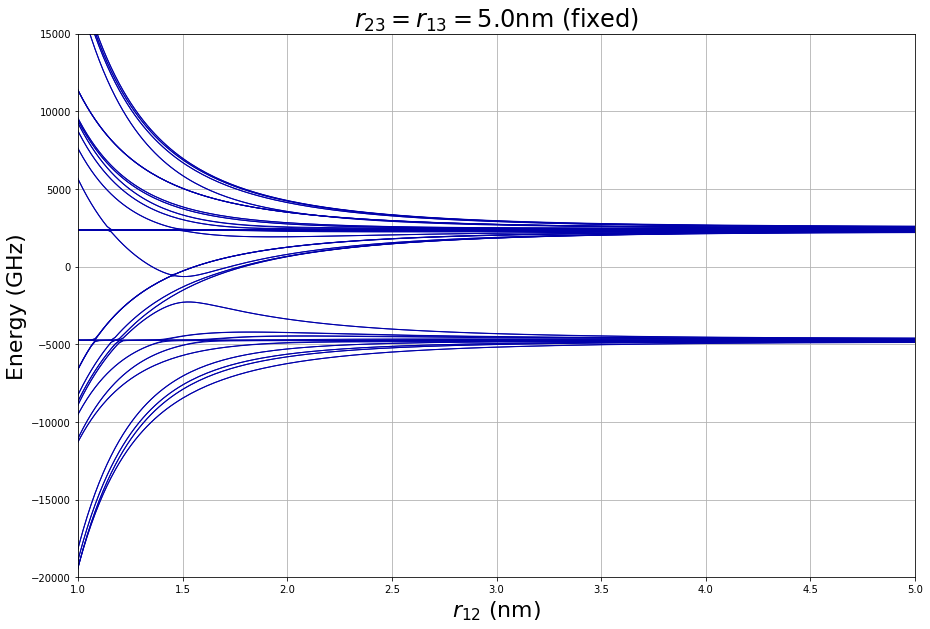

In [515]:
fig, ax = plt.subplots(figsize=(15, 10))
colors, _ = misc.getColors(len(misc.transpose(data))+1)
linestyles = ['-',':','--']
for datanum, (mdata, color) in enumerate(zip(misc.transpose(data), colors)):
    #print(len(mdata))
    ax.plot(Rvals[:len(mdata)*incr:incr]*1e9, np.array(mdata) * 1e-9 / mc.h, linewidth=1, label=datanum, color='#0000AA', linestyle='-')
#ax.legend(ncol=5)
ax.set_xlim(1,5)
ax.set_xlabel(r'$r_{12}$ (nm)',fontsize=22)
ax.set_ylim(-20000,15000)
ax.grid()
ax.set_title('$r_{23} = r_{13} = ' + str(r_13*1e9) + " $nm (fixed)", fontsize=24);
ax.set_ylabel('Energy (GHz)', fontsize=22)
plt.savefig('3BodyEnergyDiagrams/' + '$r_{23} = r_{13} = ' + str(r_13*1e9) + " $nm (fixed)" + ".png")

### basic single interaction in expanded basis

In [402]:
data = []
incr = 50

for num, H_ in enumerate(HamiltoniansAtAllPositions[::incr]):
    misc.reportProgress(num, len(HamiltoniansAtAllPositions[::incr]))
    #int short for interaction...
    int12 = convertHTo3Atom(H_, lsBasisR3, lsBasisR, [3,2] ) 
    int13 = 0
    int23 = 0
    totalEnergy = int12 + int13 + int23 + fsOp_LS3 * 2 * DeltaVal / 3 
    eigVals = np.linalg.eigvalsh(totalEnergy)
    data.append(eigVals)

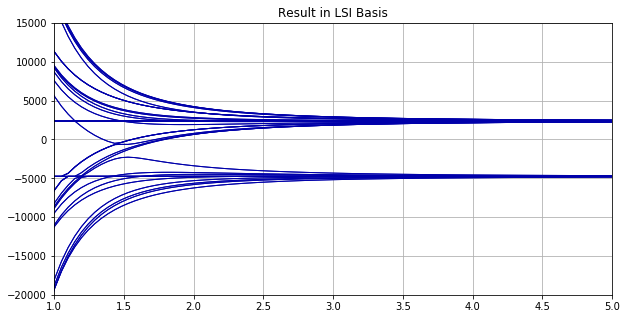

In [403]:
fig, ax = plt.subplots(figsize=(10, 5))
colors, _ = misc.getColors(len(misc.transpose(data))+1)
linestyles = ['-',':','--']
for datanum, (mdata, color) in enumerate(zip(misc.transpose(data), colors)):
    ax.plot(Rvals[::incr]*1e9, np.array(mdata) * 1e-9 / mc.h, linewidth=1, label=datanum, color='#0000AA', linestyle='-')
#ax.legend(ncol=5)
ax.set_xlim(1,5)
ax.set_ylim(-20000,15000)
ax.grid()
ax.set_title('Result in LSI Basis');

## problems with extra couplings...

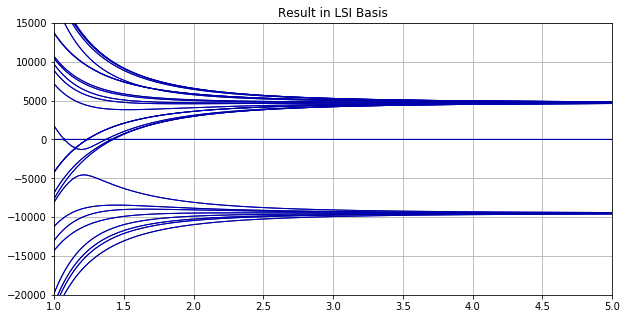

In [343]:
fig, ax = plt.subplots(figsize=(10, 5))
colors, _ = misc.getColors(len(misc.transpose(data))+1)
linestyles = ['-',':','--']
for datanum, (mdata, color) in enumerate(zip(misc.transpose(data), colors)):
    ax.plot(Rvals[::incr]*1e9, np.array(mdata) * 1e-9 / mc.h, linewidth=1, label=datanum, color='#0000AA', linestyle='-')
#ax.legend(ncol=5)
ax.set_xlim(1,5)
ax.set_ylim(-20000,15000)
ax.grid()
ax.set_title('Result in LSI Basis');

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
colors, _ = misc.getColors(len(misc.transpose(data))+1)
linestyles = ['-',':','--']
for datanum, (mdata, color) in enumerate(zip(misc.transpose(data), colors)):
    ax.plot(Rvals[::incr]*1e9, np.array(mdata) * 1e-9 / mc.h, linewidth=1, label=datanum, color='#0000AA', linestyle='-')
#ax.legend(ncol=5)
ax.set_xlim(1,5)
ax.set_ylim(-20000,15000)
ax.grid()
ax.set_title('Result in LSI Basis');

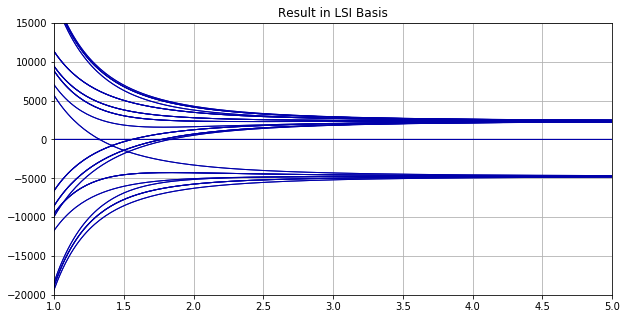

In [318]:
fig, ax = plt.subplots(figsize=(10, 5))
colors, _ = misc.getColors(len(misc.transpose(data))+1)
linestyles = ['-',':','--']
for datanum, (mdata, color) in enumerate(zip(misc.transpose(data), colors)):
    ax.plot(Rvals[::incr]*1e9, np.array(mdata) * 1e-9 / mc.h, linewidth=1, label=datanum, color='#0000AA', linestyle='-')
#ax.legend(ncol=5)
ax.set_xlim(1,5)
ax.set_ylim(-20000,15000)
ax.grid()
ax.set_title('Result in LSI Basis');

For reference:
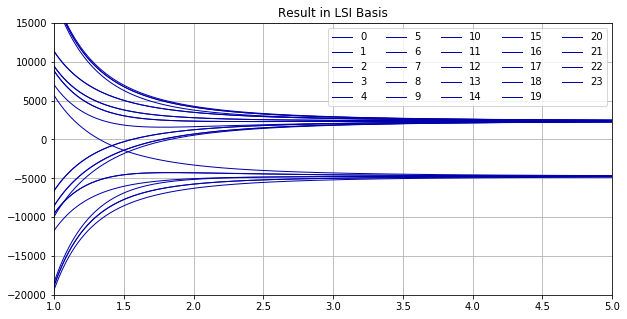

# 3-Atoms

In [65]:
import numpy as np
np.set_printoptions(precision=1,suppress=True,linewidth=100000, edgeitems=10000)
from IPython.display import Latex
import MarksConstants as mc
import Miscellaneous as misc
import matplotlib.pyplot as plt
import sympy as sp
sp.init_printing(use_latex=True)
from sympy.physics.quantum import Bra, Ket, qapply, Dagger as Dag
from sympy.physics.quantum.cg import CG

In [66]:
def J_to_LS(lsiBasis, jiBasis):
    assert(len(lsiBasis)==len(jiBasis))
    op = np.zeros((len(lsiBasis),len(jiBasis)))
    for lsnum, lsiState in enumerate(lsiBasis):
        for jnum, jiState in enumerate(jiBasis):
            # there should be some repeats because of the i values in each basis unless I=0
            L1, mL1, S1, mS1, I_lsi1, mI_lsi1 = [lsiState[key] for key in ['L_1','mL_1','S_1','mS_1', 'I_1', 'mI_1']]
            J1, mJ1, JL1, JS1, I_ji1, mI_ji1 = [jiState[key] for key in ['J_1','mJ_1', 'L_1', 'S_1', 'I_1', 'mI_1']]
            L2, mL2, S2, mS2, I_lsi2, mI_lsi2 = [lsiState[key] for key in ['L_2','mL_2','S_2','mS_2', 'I_2', 'mI_2']]
            J2, mJ2, JL2, JS2, I_ji2, mI_ji2 = [jiState[key] for key in ['J_2','mJ_2', 'L_2', 'S_2', 'I_2', 'mI_2']]
            # needing to handle this case makes me feel like the actual clebsh gordon coef should be written as
            # <L,mL,S,mS|J,mJ,L2,S2> or so instead of <L,mL,S,mS|J,mJ> as it usually is written. 
            if JL1 != L1 or JS1 != S1 or I_lsi1 != I_ji1 or mI_lsi1 != mI_ji1:
                op[jnum,lsnum] = 0
            elif JL2 != L2 or JS2 != S2 or I_lsi2 != I_ji2 or mI_lsi2 != mI_ji2:
                op[jnum,lsnum] = 0
            else:
                op[jnum,lsnum] += float(CG(L1, mL1, S1, mS1, J1, mJ1).doit())*float(CG(L2, mL2, S2, mS2, J2, mJ2).doit())
    return op

In [67]:
def createLargerBasisRefs3Atoms(Lvals, Svals, Ivals, forceExcited=False):
    fBasisRef = []
    for Lv in Lvals:
        for Sv in Svals:
            Jvals = set(np.arange(abs(Sv - Lv), Sv + Lv+1, 1))
            for Jv in Jvals:
                for Iv in Ivals:
                    FVals = set(np.arange(abs(Jv - Iv), Jv + Iv+1, 1))
                    for Fv in FVals:
                        for mf in np.arange(-Fv,Fv+1,1):
                            fBasisRef.append(multiplyableDictMulti({"F":Fv, "mF": mf, "J":Jv, "L":Lv, "S":Sv, "I":Iv}))
    jiBasisRef = []
    for Lv in Lvals:
        for Sv in Svals:
            Jvals = set(np.arange(abs(Sv - Lv), Sv + Lv+1, 1))
            for Jv in Jvals:
                for mJ in np.arange(-Jv,Jv+1,1):
                    for Iv in Ivals:
                        for mi in np.arange(-Iv,Iv+1,1):
                            jiBasisRef.append(multiplyableDictMulti({"J":Jv, "mJ":mJ, "L":Lv, "S":Sv, "I":Iv, "mI":mi}))
    lsiBasisRef = []
    for Lv in Lvals:
        for mL in np.arange(-Lv,Lv+1,1):
            for Sv in Svals:
                for mS in np.arange(-Sv, Sv+1,1):
                    for Iv in Ivals:
                        for mi in np.arange(-Iv,Iv+1,1):
                            lsiBasisRef.append(multiplyableDictMulti({"L":Lv, "mL":mL, "S":Sv, "mS":mS, "I":Iv, "mI":mi}))
    return lsiBasisRef, jiBasisRef, fBasisRef, np.kron(np.kron(lsiBasisRef,lsiBasisRef),lsiBasisRef), np.kron(np.kron(jiBasisRef,jiBasisRef), jiBasisRef), np.kron(np.kron(fBasisRef,fBasisRef), fBasisRef)

In [68]:
def createBornOppenheimerBasisHFS(Lvals, Svals, Ivals, sigmavals=["g","u"]):
    # Normal Notaion is |L Lambda sigma S Sigma>, but I need to keep track of more than that for the splittings caused by other interactions.
    # Therefore this creates a very big basis which is probably unnecessary, but the size of the matrices isn't actually prohibitive in these 
    # calculations so it's okay to have degeneracies.
    boBasisRef = []
    for sigma in sigmavals:
        for Lv in Lvals:
            for Lambda in np.arange(-Lv,Lv+1,1):
                for Sv in Svals:
                    for Sigma in np.arange(-Sv, Sv+1,1):
                        for i1 in Ivals:
                            for i2 in Ivals:
                                for I in np.arange(abs(i2-i1), i2+i1+1,1):
                                    for iota in np.arange(-I,I+1,1):
                                        state = multiplyableDictMulti({"L":Lv, "Lambda": Lambda, "sigma": sigma, "S":Sv, "Sigma":Sigma, "i":I, "iota":iota, "i1":i1, "i2":i2,
                                                                  "Omega":Sigma+Lambda, "phi": Sigma+Lambda+iota })
                                        if state not in boBasisRef:
                                            boBasisRef.append(state)
    boBasisRef = list(sorted(boBasisRef, key=lambda state: abs(state["Omega"]) + 100 * ord(state["sigma"])))
    boBasisFancy = []
    for state in boBasisRef:
        spinT = 2*state["S"]+1
        omega = state["Omega"]
        parity = state["sigma"]
        LambdaSymbol = "\Sigma" if state["Lambda"]==0 else "\Pi"
        boBasisFancy.append(Latex(r"$^{"+str(spinT)+ "}" + LambdaSymbol + "_{"+ str(abs(omega)) + "," + parity + "}$"))        
    return boBasisRef, boBasisFancy

In [69]:
def fsOp3(basis):
    # expects a two-particle basis, so each element of the basis should 
    # have J_1, mJ_1, L_1, S_1, and J_2, mJ_2, L_2, S_2 values.
    op = np.zeros((len(basis),len(basis)))
    J1,mJ1,L1,S1,J2,mJ2,L2,S2 = [0 for _ in range(8)]
    names = ['J','mJ','L','S']
    for s1num, state1 in enumerate(basis):
        for s2num, state2 in enumerate(basis):
            val = 1
            qNums = [0 for _ in range(8)]
            for num, name in enumerate(names):
                if state2[name+"_1"] != state1[name+"_1"]:
                    # matrix is diagonal.
                    val = 0
                qNums[num] = state1[name+"_1"]
            for num, name in enumerate(names):
                if state2[name+"_2"] != state1[name+"_2"]:
                    # matrix is diagonal.
                    val = 0
                qNums[num+4] = state1[name+"_2"]
            J1,mJ1,L1,S1,J2,mJ2,L2,S2 = qNums
            # the matrix element is A/2 (L1 . S1 + L2 . S2), A=1
            val *= 0.5*(J1*(J1+1)-L1*(L1+1)-S1*(S1+1)+ J2*(J2+1)-L2*(L2+1)-S2*(S2+1) )
            op[s1num,s2num] = val            
    return op

In [70]:
g = 0
u = 1

In [71]:
class multiplyableDictMulti(dict):
    # This class exists so that I can take a basis ref and use it in np.kron()
    # to programatically get the basis ref for multi-particle systems.
    def __mul__(self, other):
        #assert(type(other) == type(self))
        newDict = multiplyableDictMulti()
        for key, value in self.items():
            keyCore = key
            if len(keyCore) > 1 and keyCore[-2] == "_":
                keyCore = keyCore[:-2]
            for num in range(3):
                if keyCore + "_" + str(num+1) not in newDict:
                    newDict.update({keyCore+"_" + str(num+1): value})
                    break
        for key, value in other.items():
            keyCore = key
            if len(keyCore) > 1 and  keyCore[-2] == "_":
                keyCore = keyCore[:-2]
            for num in range(3):
                if keyCore + "_" + str(num+1) not in newDict:
                    newDict.update({keyCore+"_" + str(num+1): value})
                    break
        return newDict

In [72]:
def BohrOppenheimerToAtomic( oalNums, spinNums, nuclearNums, sigma, 
                             lsBasis, 
                             basisChange=None, naturalKronBasis=None, finalBasis=None ):
    """
    oalNums = (L, Lambda, la, lb)
    L is the total molecular orbital angular momentum \vec{L} = \vec{l1}+\vec{l2}
    Lambda is the projection of L on the internuclear axis.
    l1 is the orbital angular momentum of atom 1.
    l2 is the orbital angular momentum of atom 2.
    
    spinNums = (S, Sigma, sa, sb)
    S is the total molecular spin angular momentum \vec{s} = \vec{s1}+\vec{s2}
    Sigma is the projection of S on the internuclear axis.
    s1 is the spin angular momentum of atom 1.
    s2 is the spin angular momentum of atom 2.
    
    nuclearNums = (I, iota, ia, ib)
    
    sigma is the spatial symmetry of the electronic wavefunctions, 
        either 0 for g ("gerude" or symmetric wavefunctions) 
        or 1 for u ("ungerude" or antisymmetric wavefunctions)
    """
    (L, Lambda, la, lb) = oalNums
    (S, Sigma, sa, sb) = spinNums
    (I, iota, ia, ib) = nuclearNums
    state = 0
    p = (-1)**(S+sigma)
    indvCont = []
    lsiBasisStates = []
    otherBasisStates = []
    for mla in np.arange(-la,la+1,1):
        mlb = Lambda-mla
        if abs(mlb) > lb:
            continue
        for msa in np.arange(-sa,sa+1,1):
            msb = Sigma-msa
            if abs(msb) > sb:
                continue
            for mia in np.arange(-ia, ia+1, 1):
                mib = iota-mia
                if abs(mib) > ib:
                    continue
                # CG notation is <j1,mj1,j2,mj2|j3,mj3>
                oalCoef = float(CG(la,mla,lb,mlb,L,Lambda).doit())
                spinCoef = float(CG(sa,msa,sb,msb,S,Sigma).doit())
                nuclearCoef = float(CG(ia,mia,ib,mib,I,iota).doit())
                aState1 = getColumnState(lsiBasis, {'L':la,'mL':mla,'S':sa,'mS':msa, 'I':ia,'mI':mia})
                bState1 = getColumnState(lsiBasis, {'L':lb,'mL':mlb,'S':sb,'mS':msb, 'I':ib,'mI':mib})
                aState2 = getColumnState(lsiBasis, {'L':lb,'mL':mlb,'S':sa,'mS':msa, 'I':ia,'mI':mia})
                bState2 = getColumnState(lsiBasis, {'L':la,'mL':mla,'S':sb,'mS':msb, 'I':ib,'mI':mib})
                if oalCoef != 0 and nuclearCoef != 0 and spinCoef != 0:
                    lsiBasisStates.append([aState1, bState1, aState2, bState2])
                if basisChange is not None:
                    aState1 = basisChange@aState1
                    bState1 = basisChange@bState1
                    aState2 = basisChange@aState2
                    bState2 = basisChange@bState2
                newpart = nuclearCoef*oalCoef*spinCoef * (np.kron(aState1,bState1) + p * np.kron(aState2,bState2))
                
                state += newpart
                if oalCoef != 0 and nuclearCoef != 0 and spinCoef != 0:
                    indvCont.append(newpart)
                    otherBasisStates.append([aState1, bState1, aState2, bState2])
    if np.linalg.norm(state) == 0:
        raise ValueError("State has zero norm!")
    state /= np.linalg.norm(state)
    if finalBasis is not None:
        state = convertToReducedBasis(state, finalBasis, naturalKronBasis)
    return state, np.array(indvCont), np.array(lsiBasisStates), np.array(otherBasisStates)

In [73]:
# plugging in zero nuclear spin effectively avoids i in all of these bases. 
lsiBasis, jiBasis, fBasis, lsiBasis3Atom, jiBasis3Atom, fBasis3Atom = createLargerBasisRefs3Atoms([0,1], [1/2], [0])
lsBasisR, jBasisR = [], []
for state in lsiBasis3Atom:
    if (state['L_1'] == 0 and state['L_2'] == 0) or (state['L_1'] == 1 and state['L_2'] == 1):
        continue
    lsBasisR.append(state)
for state in jiBasis3Atom:
    if (state['L_1'] == 0 and state['L_2'] == 0) or (state['L_1'] == 1 and state['L_2'] == 1):
        continue
    jBasisR.append(state)
fsOperator = fsOp3(jBasisR)
J_to_LS_op = J_to_LS(lsBasisR,jBasisR)
fsOp_LS = J_to_LS_op@fsOperator@J_to_LS_op.T
print(len(lsBasisR))
lsiToJiop = lsiToJi(lsiBasis,jiBasis)
#print(lsiToJiop.shape)
#fsLsi = lsiToJiop.T@fsOperator@lsiToJiop
#boBasisDict_g, boBasisLatex_g = createBornOppenheimerBasisHFS([1],[0,1], [0], sigmavals=['g'])
#boBasisDict_u, boBasisLatex_u = createBornOppenheimerBasisHFS([1],[0,1], [0], sigmavals=['u'])
boBasisDict_full, boBasisLatex_full = createBornOppenheimerBasisHFS([1],[0,1], [0], sigmavals=['g', 'u'])

192


In [74]:
boBasis = boBasisDict_full

In [75]:
boToAtomicMatrix = []
for st in boBasis: 
    sigmaV = g if st['sigma']=='g' else u
    phase = (-1)**(sigmaV+st['S'])
    state1, _,_,_ = BohrOppenheimerToAtomic( [st['L'],st['Lambda'],st['L'],0],
                                                [st['S'],st['Sigma'],1/2,1/2],
                                                [st['i'],st['iota'],0,0],
                                                sigmaV, lsiBasis, basisChange=lsiToJiop, naturalKronBasis=jiBasis2Atom, finalBasis=jBasisR)
    boToAtomicMatrix.append(state1.T[0])
boToAtomicMatrix = np.array(boToAtomicMatrix)


AssertionError: 

In [ ]:
A_gs = (mc.Rb87_Ground_ToF2-mc.Rb87_Ground_ToF1)/2
A_12 = (mc.Rb87_5P12_ToF2-mc.Rb87_5P12_ToF1)/2
A_32 = (mc.Rb87_5P32_ToF3-mc.Rb87_5P32_ToF0)/6

In [ ]:
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h
C_3_val = mc.Rb87_C3
print(DeltaVal, C_3_val)

In [ ]:
print(getColumnState(jBasisR, jBasisR[2]))
print(jBasisR[-2])
print(lsBasisR[-2])

In [ ]:
def HC(matrix):
    return matrix.conj().T

In [ ]:
toAtomic = boToAtomicMatrix@HC(J_to_LS_op)

In [ ]:
Rvals = np.linspace( 0.5*20*mc.a0, 5*20*mc.a0, 5000 )
data = []
rotMatrix = fullRotation(1)
for rnum, rv in enumerate(Rvals):
    misc.reportProgress(rnum, len(Rvals))
    #t1 = J_to_LS_op@boToAtomicMatrix.T@createBOMatrix2(C_3_val, rv, *boBasis).astype(float)@boToAtomicMatrix@J_to_LS_op.T
    t1 = HC(toAtomic)@createBOMatrix2(C_3_val, rv, *boBasis).astype(float)@toAtomic
    t2 = fsOp_LS * 2 * DeltaVal / 3
    rmatrix = t1 + t2
    rotatedH = HC(rotMatrix)@rmatrix@rotMatrix
    eigVals = np.linalg.eigvalsh(rotatedH)
    data.append(eigVals)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
colors, _ = misc.getColors(len(misc.transpose(data))+1)
linestyles = ['-',':','--']
for datanum, (mdata, color) in enumerate(zip(misc.transpose(data), colors)):
    ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, linewidth=1, label=datanum, color='#0000AA', linestyle='-')
ax.legend(ncol=5)
ax.set_xlim(1,5)
ax.set_ylim(-20000,15000)
ax.grid()
ax.set_title('Result in LSI Basis');